In [1]:
import csv
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

In [2]:
# File Paths
DATA_DIR = "/home/jupyter/runwai/data"
IMAGES_DIR = f"{DATA_DIR}/images"
LABELS_DIR = f"{DATA_DIR}/labels"
SPLIT_DIR = f"{DATA_DIR}/split"
ORIGINAL_CSV = f"{LABELS_DIR}/small_labels.csv"
TRAIN_CSV = f"{SPLIT_DIR}/train.csv"
VAL_CSV = f"{SPLIT_DIR}/val.csv"

In [3]:
# delete output files to avoid duplicates and overriding
#train.csv
import shutil
if os.path.exists("/home/jupyter/runwai/logs"):
    shutil.rmtree("/home/jupyter/runwai/logs")
    print("Logs from previos run are deleted")
else:
    print("No logs from previous run")

No logs from previous run


In [4]:
#Consts
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
INPUT_SHAPE = (224, 224)

In [5]:
class AttributesDataset():
    def __init__(self, annotation_path):
        upper_fabric_labels = []
        lower_fabric_labels = []
        outer_fabric_labels = []
        
        upper_color_labels = []
        lower_color_labels = []
        outer_color_labels = []
        
        sleeve_len_labels = []
        lower_clothing_len_labels = []
        neckline_labels = []

        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                upper_fabric_labels.append(row['upper_fabric'])
                lower_fabric_labels.append(row['lower_fabric'])
                outer_fabric_labels.append(row['outer_fabric'])
                
                upper_color_labels.append(row['upper_color'])
                lower_color_labels.append(row['lower_color'])
                outer_color_labels.append(row['outer_color'])
                
                sleeve_len_labels.append(row['sleeve_len'])
                lower_clothing_len_labels.append(row['lower_clothing_len'])
                neckline_labels.append(row['neckline'])
                
        #### Get unique labels
        self.upper_fabric_labels = np.unique(upper_fabric_labels)
        self.lower_fabric_labels = np.unique(lower_fabric_labels)
        self.outer_fabric_labels = np.unique(outer_fabric_labels)
        
        self.upper_color_labels = np.unique(upper_color_labels)
        self.lower_color_labels = np.unique(lower_color_labels)
        self.outer_color_labels = np.unique(outer_color_labels)
        
        self.sleeve_len_labels = np.unique(sleeve_len_labels)
        self.lower_clothing_len_labels = np.unique(lower_clothing_len_labels)
        self.neckline_labels = np.unique(neckline_labels)
        
        #### Get number of unique labels
        self.num_upper_fabric_labels = len(self.upper_fabric_labels)
        self.num_lower_fabric_labels = len(self.lower_fabric_labels)
        self.num_outer_fabric_labels = len(self.outer_fabric_labels)
        
        self.num_upper_color_labels = len(self.upper_color_labels)
        self.num_lower_color_labels = len(self.lower_color_labels)
        self.num_outer_color_labels = len(self.outer_color_labels)
        
        self.num_sleeve_len_labels = len(self.sleeve_len_labels)
        self.num_lower_clothing_len_labels = len(self.lower_clothing_len_labels)
        self.num_neckline_labels = len(self.neckline_labels)
        
        #### Methods to go back and firth between labels and corresponding numbers
        # fabric
        self.fabric_id_to_name = dict(zip(range(len(self.upper_fabric_labels)), self.upper_fabric_labels))
        self.fabric_name_to_id = dict(zip(self.upper_fabric_labels, range(len(self.upper_fabric_labels))))
        
        # color
        self.color_id_to_name = dict(zip(range(len(self.upper_color_labels)), self.upper_color_labels))
        self.color_name_to_id = dict(zip(self.upper_color_labels, range(len(self.upper_color_labels))))
        
        # sleeve length
        self.sleeve_id_to_name = dict(zip(range(len(self.sleeve_len_labels)), self.sleeve_len_labels))
        self.sleeve_name_to_id = dict(zip(self.sleeve_len_labels, range(len(self.sleeve_len_labels))))
        
        # bottoms length
        self.bottoms_id_to_name = dict(zip(range(len(self.lower_clothing_len_labels)), self.lower_clothing_len_labels))
        self.bottoms_name_to_id = dict(zip(self.lower_clothing_len_labels, range(len(self.lower_clothing_len_labels))))
        
        # neckline
        self.neckline_id_to_name = dict(zip(range(len(self.neckline_labels)), self.neckline_labels))
        self.neckline_name_to_id = dict(zip(self.neckline_labels, range(len(self.neckline_labels))))
        

In [6]:
class FashionDataset(Dataset):
    def __init__(self, annotation_path, attributes, transform=None):
        super().__init__()

        self.transform = transform
        self.attr = attributes

        # initialize the arrays to store the ground truth labels and paths to the images
        self.data = []
        self.upper_fabric_labels = []
        self.lower_fabric_labels = []
        self.outer_fabric_labels = []
        
        self.upper_color_labels = []
        self.lower_color_labels = []
        self.outer_color_labels = []
        
        self.sleeve_len_labels = []
        self.lower_clothing_len_labels = []
        self.neckline_labels = []

        # read the annotations from the CSV file
        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.data.append(row['image_path'])
                self.upper_fabric_labels.append(self.attr.fabric_name_to_id[row['upper_fabric']])
                self.lower_fabric_labels.append(self.attr.fabric_name_to_id[row['lower_fabric']])
                self.outer_fabric_labels.append(self.attr.fabric_name_to_id[row['outer_fabric']])
                
                self.upper_color_labels.append(self.attr.color_name_to_id[row['upper_color']])
                self.lower_color_labels.append(self.attr.color_name_to_id[row['lower_color']])
                self.outer_color_labels.append(self.attr.color_name_to_id[row['outer_color']])
                
                self.sleeve_len_labels.append(self.attr.sleeve_name_to_id[row['sleeve_len']])
                self.lower_clothing_len_labels.append(self.attr.bottoms_name_to_id[row['lower_clothing_len']])
                self.neckline_labels.append(self.attr.neckline_name_to_id[row['neckline']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # take the data sample by its index
        img_path = self.data[idx]

        # read image
        img = Image.open(img_path)

        # apply the image augmentations if needed
        if self.transform:
            img = self.transform(img)

        # return the image and all the associated labels
        dict_data = {
            'img': img,
            'labels': {
                'upper_fabric_labels': self.upper_fabric_labels[idx],
                'lower_fabric_labels': self.lower_fabric_labels[idx],
                'outer_fabric_labels': self.outer_fabric_labels[idx],
                
                'upper_color_labels': self.upper_color_labels[idx],
                'lower_color_labels': self.lower_color_labels[idx],
                'outer_color_labels': self.outer_color_labels[idx],
                
                'sleeve_len_labels': self.sleeve_len_labels[idx],
                'lower_clothing_len_labels': self.lower_clothing_len_labels[idx],
                'neckline_labels': self.neckline_labels[idx]           
            }
        }
        return dict_data

In [7]:
# from model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class MultiOutputModel(nn.Module):
    def __init__(self, n_upper_fabric_classes, n_lower_fabric_classes, n_outer_fabric_classes,\
                n_upper_color_classes, n_lower_color_classes, n_outer_color_classes, 
                n_sleeve_len_classes, n_lower_clothing_len_classes, n_neckline_classes):
        super().__init__()
        self.base_model = models.mobilenet_v2().features  # take the model without classifier
        last_channel = models.mobilenet_v2().last_channel  # size of the layer before classifier

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        self.upper_fabric = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_upper_fabric_classes)
        )
        self.lower_fabric = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_lower_fabric_classes)
        )
        self.outer_fabric = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_outer_fabric_classes)
        )
        
        self.upper_color = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_upper_color_classes)
        )
        self.lower_color = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_lower_color_classes)
        )
        self.outer_color = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_outer_color_classes)
        )
        
        self.sleeve_len = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_sleeve_len_classes)
        )
        self.lower_clothing_len = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_lower_clothing_len_classes)
        )
        self.neckline = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_neckline_classes)
        )


    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return {
            'upper_fabric': self.upper_fabric(x),
            'lower_fabric': self.lower_fabric(x),
            'outer_fabric': self.outer_fabric(x),
            'upper_color': self.upper_color(x),
            'lower_color': self.lower_color(x),
            'outer_color': self.outer_color(x),
            'sleeve_len': self.sleeve_len(x),
            'lower_clothing_len': self.lower_clothing_len(x),
            'neckline': self.neckline(x)
        }

    def get_loss(self, net_output, ground_truth):
        upper_fabric_loss = F.cross_entropy(net_output['upper_fabric'], ground_truth['upper_fabric_labels'])
        lower_fabric_loss = F.cross_entropy(net_output['lower_fabric'], ground_truth['lower_fabric_labels'])
        outer_fabric_loss = F.cross_entropy(net_output['outer_fabric'], ground_truth['outer_fabric_labels'])
        
        upper_color_loss = F.cross_entropy(net_output['upper_color'], ground_truth['upper_color_labels'])
        lower_color_loss = F.cross_entropy(net_output['lower_color'], ground_truth['lower_color_labels'])
        outer_color_loss = F.cross_entropy(net_output['outer_color'], ground_truth['outer_color_labels'])
        
        sleeve_len_loss = F.cross_entropy(net_output['sleeve_len'], ground_truth['sleeve_len_labels'])
        lower_clothing_len_loss = F.cross_entropy(net_output['lower_clothing_len'], \
                                                  ground_truth['lower_clothing_len_labels'])
        neckline_loss = F.cross_entropy(net_output['neckline'], ground_truth['neckline_labels'])
        
        loss = upper_fabric_loss + lower_fabric_loss + outer_fabric_loss + \
                upper_color_loss + lower_color_loss + outer_color_loss +\
                sleeve_len_loss + lower_clothing_len_loss + neckline_loss
        
        return loss, {'upper_fabric': upper_fabric_loss, 'lower_fabric': lower_fabric_loss, 'outer_fabric': outer_fabric_loss,
                     'upper_color': upper_color_loss, 'lower_color': lower_color_loss, 'outer_color': outer_color_loss,
                     'sleeve_len': sleeve_len_loss, 'lower_clothing_len': lower_clothing_len_loss, 'neckline': neckline_loss,}

In [8]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def calculate_metrics(output, target):
    ### fabric
    _, predicted_upper_fabric = output['upper_fabric'].cpu().max(1)
    gt_upper_fabric = target['upper_fabric_labels'].cpu()

    _, predicted_lower_fabric = output['lower_fabric'].cpu().max(1)
    gt_lower_fabric = target['lower_fabric_labels'].cpu()
    
    _, predicted_outer_fabric = output['outer_fabric'].cpu().max(1)
    gt_outer_fabric = target['outer_fabric_labels'].cpu()
    
    ### color
    _, predicted_upper_color = output['upper_color'].cpu().max(1)
    gt_upper_color = target['upper_color_labels'].cpu()
    
    _, predicted_lower_color = output['lower_color'].cpu().max(1)
    gt_lower_color = target['lower_color_labels'].cpu()
    
    _, predicted_outer_color = output['outer_color'].cpu().max(1)
    gt_outer_color = target['outer_color_labels'].cpu()
    
    ### others
    _, predicted_sleeve_len = output['sleeve_len'].cpu().max(1)
    gt_sleeve_len = target['sleeve_len_labels'].cpu()
    
    _, predicted_lower_clothing_len = output['lower_clothing_len'].cpu().max(1)
    gt_lower_clothing_len = target['lower_clothing_len_labels'].cpu()
    
    _, predicted_neckline = output['neckline'].cpu().max(1)
    gt_neckline = target['neckline_labels'].cpu()
    

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_upper_fabric = accuracy_score(y_true=gt_upper_fabric.numpy(), y_pred=predicted_upper_fabric.numpy())
        accuracy_lower_fabric = accuracy_score(y_true=gt_lower_fabric.numpy(), y_pred=predicted_lower_fabric.numpy())
        accuracy_outer_fabric = accuracy_score(y_true=gt_outer_fabric.numpy(), y_pred=predicted_outer_fabric.numpy())
        
        accuracy_upper_color = accuracy_score(y_true=gt_upper_color.numpy(), y_pred=predicted_upper_color.numpy())
        accuracy_lower_color = accuracy_score(y_true=gt_lower_color.numpy(), y_pred=predicted_lower_color.numpy())
        accuracy_outer_color = accuracy_score(y_true=gt_outer_color.numpy(), y_pred=predicted_outer_color.numpy())
        
        accuracy_sleeve_len = accuracy_score(y_true=gt_sleeve_len.numpy(), y_pred=predicted_sleeve_len.numpy())
        accuracy_lower_clothing_len = accuracy_score(y_true=gt_lower_clothing_len.numpy(), y_pred=predicted_lower_clothing_len.numpy())
        accuracy_neckline = accuracy_score(y_true=gt_neckline.numpy(), y_pred=predicted_neckline.numpy())
        
    # print("CALCULATE METRICS RESULTS")
    # print(accuracy_upper_fabric, accuracy_lower_fabric, accuracy_outer_fabric, accuracy_upper_color, accuracy_lower_color, accuracy_outer_color, accuracy_sleeve_len, accuracy_lower_clothing_len, accuracy_neckline, sep="\n")

    return accuracy_upper_fabric, accuracy_lower_fabric, accuracy_outer_fabric, accuracy_upper_color, accuracy_lower_color, accuracy_outer_color, accuracy_sleeve_len, accuracy_lower_clothing_len, accuracy_neckline

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_gt_data(dataset, attributes):
    imgs = []
    gt_labels = []

    n_cols = 5
    n_rows = 3

    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for img_idx in range(n_cols * n_rows):
        sample = dataset[img_idx]
        img = sample['img']
        labels = sample['labels']

        gt_upper_fabric = attributes.fabric_id_to_name[labels['upper_fabric_labels']]
        gt_lower_fabric = attributes.fabric_id_to_name[labels['lower_fabric_labels']]
        gt_outer_fabric = attributes.fabric_id_to_name[labels['outer_fabric_labels']]
        
        gt_upper_color = attributes.color_id_to_name[labels['upper_color_labels']]
        gt_lower_color = attributes.color_id_to_name[labels['lower_color_labels']]
        gt_outer_color = attributes.color_id_to_name[labels['outer_color_labels']]
        
        gt_sleeve_len = attributes.sleeve_id_to_name[labels['sleeve_len_labels']]
        gt_lower_clothing_len = attributes.bottoms_id_to_name[labels['lower_clothing_len_labels']]
        gt_neckline = attributes.neckline_id_to_name[labels['neckline_labels']]
        
        imgs.append(img)
        gt_labels.append("{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}".format(gt_upper_fabric, 
                                                                     gt_lower_fabric, 
                                                                     gt_outer_fabric,
                                                                     gt_upper_color, 
                                                                     gt_lower_color, 
                                                                     gt_outer_color,
                                                                     gt_sleeve_len, 
                                                                     gt_lower_clothing_len, 
                                                                     gt_neckline))

    title = "Ground truth labels"

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, gt_labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # restore original transforms
    dataset.transform = transforms

In [10]:
def checkpoint_load(model, name):
    print('Restoring checkpoint: {}'.format(name))
    model.load_state_dict(torch.load(name, map_location='cpu'))
    epoch = int(os.path.splitext(os.path.basename(name))[0].split('-')[1])
    return epoch


def net_output_to_predictions(output):
    
    ### fabric
    _, predicted_upper_fabric = output['upper_fabric'].cpu().max(1)
    _, predicted_lower_fabric = output['lower_fabric'].cpu().max(1)
    _, predicted_outer_fabric = output['outer_fabric'].cpu().max(1)

    ### color
    _, predicted_upper_color = output['upper_color'].cpu().max(1)
    _, predicted_lower_color = output['lower_color'].cpu().max(1)
    _, predicted_outer_color = output['outer_color'].cpu().max(1)
    
    ### others
    _, predicted_sleeve_len = output['sleeve_len'].cpu().max(1)
    _, predicted_lower_clothing_len = output['lower_clothing_len'].cpu().max(1)
    _, predicted_neckline = output['neckline'].cpu().max(1)
    
    return  predicted_upper_fabric.numpy().tolist(), \
            predicted_lower_fabric.numpy().tolist(), \
            predicted_outer_fabric.numpy().tolist(), \
            predicted_upper_color.numpy().tolist(), \
            predicted_lower_color.numpy().tolist(), \
            predicted_outer_color.numpy().tolist(), \
            predicted_sleeve_len.numpy().tolist(), \
            predicted_lower_clothing_len.numpy().tolist(), \
            predicted_neckline.numpy().tolist()


def validate(model, dataloader, device, logger=None, epoch=None, checkpoint=None):
    if checkpoint is not None:
        checkpoint_load(model, checkpoint)

    model.eval()
    upper_fabric_predictions = []
    lower_fabric_predictions = []
    outer_fabric_predictions = []
    
    upper_color_predictions = []
    lower_color_predictions = []
    outer_color_predictions = []
    
    sleeve_len_predictions = []
    lower_clothing_len_predictions = []
    neckline_predictions = []
    
    with torch.no_grad():
        avg_loss = 0
        accuracy_upper_fabric = 0
        accuracy_lower_fabric = 0
        accuracy_outer_fabric = 0
        
        accuracy_upper_color = 0
        accuracy_lower_color = 0
        accuracy_outer_color = 0
        
        accuracy_sleeve_len = 0
        accuracy_lower_clothing_len = 0
        accuracy_neckline = 0

        for batch in dataloader:
            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            val_train, val_train_losses = model.get_loss(output, target_labels)
            avg_loss += val_train.item()
            batch_accuracy_upper_fabric, batch_accuracy_lower_fabric, batch_accuracy_outer_fabric, \
            batch_accuracy_upper_color, batch_accuracy_lower_color, batch_accuracy_outer_color, \
            batch_accuracy_sleeve_len, batch_accuracy_lower_clothing_len, batch_accuracy_neckline  = \
                calculate_metrics(output, target_labels)
            
            accuracy_upper_fabric += batch_accuracy_upper_fabric
            accuracy_lower_fabric += batch_accuracy_lower_fabric
            accuracy_outer_fabric += batch_accuracy_outer_fabric
        
            accuracy_upper_color += batch_accuracy_upper_color
            accuracy_lower_color += batch_accuracy_lower_color
            accuracy_outer_color += batch_accuracy_outer_color
        
            accuracy_sleeve_len += batch_accuracy_sleeve_len
            accuracy_lower_clothing_len += batch_accuracy_lower_clothing_len
            accuracy_neckline += batch_accuracy_neckline

            (batch_upper_fabric_predictions,
            batch_lower_fabric_predictions,
            batch_outer_fabric_predictions,
            batch_upper_color_predictions,
            batch_lower_color_predictions,
            batch_outer_color_predictions,
            batch_sleeve_len_predictions,
            batch_lower_clothing_len_predictions,
            batch_neckline_predictions) = net_output_to_predictions(output)
            
            upper_fabric_predictions.extend(batch_upper_fabric_predictions)
            lower_fabric_predictions.extend(batch_lower_fabric_predictions)
            outer_fabric_predictions.extend(batch_outer_fabric_predictions)
    
            upper_color_predictions.extend(batch_upper_color_predictions)
            lower_color_predictions.extend(batch_lower_color_predictions)
            outer_color_predictions.extend(batch_outer_color_predictions)
    
            sleeve_len_predictions.extend(batch_sleeve_len_predictions)
            lower_clothing_len_predictions.extend(batch_lower_clothing_len_predictions)
            neckline_predictions.extend(batch_neckline_predictions)


    n_samples = len(dataloader)
    avg_loss /= n_samples
    accuracy_upper_fabric /= n_samples
    accuracy_lower_fabric /= n_samples
    accuracy_outer_fabric /= n_samples
    accuracy_upper_color /= n_samples
    accuracy_lower_color /= n_samples
    accuracy_outer_color /= n_samples
    accuracy_sleeve_len /= n_samples
    accuracy_lower_clothing_len /= n_samples
    accuracy_neckline /= n_samples
    print('-' * 72)
    print('VALIDATION')
    print("Validation  loss: {:.4f}, upper_fabric: {:.4f}, \
          lower_fabric: {:.4f}, outer_fabric: {:.4f}, upper_color: {:.4f}, \
          lower_color: {:.4f}, outer_color: {:.4f}, sleeve_len: {:.4f},\
          lower_clothing_len: {:.4f}, neckline: {:.4f}\n".format(avg_loss, accuracy_upper_fabric, 
                                                                 accuracy_lower_fabric, accuracy_outer_fabric, 
                                                                 accuracy_upper_color, accuracy_lower_color, 
                                                                 accuracy_outer_color, accuracy_sleeve_len, 
                                                                 accuracy_lower_clothing_len, accuracy_neckline))

#     if logger is not None and epoch is not None:
#         logger.add_scalar("val_loss", avg_loss, epoch)
#         logger.add_scalar("val_accuracy_upper_fabric", accuracy_upper_fabric, epoch)
#         logger.add_scalar("val_accuracy_lower_fabric", accuracy_lower_fabric, epoch)
#         logger.add_scalar("val_accuracy_outer_fabric", accuracy_outer_fabric, epoch)
        
#         logger.add_scalar("val_accuracy_upper_color", accuracy_upper_color, epoch)
#         logger.add_scalar("val_accuracy_lower_color", accuracy_lower_color, epoch)
#         logger.add_scalar("val_accuracy_outer_color", accuracy_outer_color, epoch)
        
#         logger.add_scalar("val_accuracy_sleeve_len", accuracy_sleeve_len, epoch)
#         logger.add_scalar("val_accuracy_lower_clothing_len", accuracy_lower_clothing_len, epoch)
#         logger.add_scalar("val_accuracy_neckline", accuracy_neckline, epoch)
    model.train()

    return upper_fabric_predictions, lower_fabric_predictions, outer_fabric_predictions, upper_color_predictions, lower_color_predictions, outer_color_predictions, sleeve_len_predictions, lower_clothing_len_predictions, neckline_predictions

In [11]:
# from train.py

import argparse
import os
from datetime import datetime

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    


def train(start_epoch=1, N_epochs=50, batch_size=128, num_workers=4):
    attributes_file = ORIGINAL_CSV
    device = torch.device('cuda')

    # attributes variable contains labels for the categories in the dataset and mapping 
    # between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # specify image transforms for augmentation during training
    train_transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                shear=None, fill=(255, 255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = FashionDataset(TRAIN_CSV, attributes, train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = FashionDataset(VAL_CSV, attributes, val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = MultiOutputModel(n_upper_fabric_classes=attributes.num_upper_fabric_labels,
                             n_lower_fabric_classes=attributes.num_lower_fabric_labels,
                             n_outer_fabric_classes=attributes.num_outer_fabric_labels,
                             n_upper_color_classes=attributes.num_upper_color_labels,
                             n_lower_color_classes=attributes.num_lower_color_labels,
                             n_outer_color_classes=attributes.num_outer_color_labels,
                             n_sleeve_len_classes=attributes.num_sleeve_len_labels,
                             n_lower_clothing_len_classes=attributes.num_lower_clothing_len_labels,
                             n_neckline_classes=attributes.num_neckline_labels)\
                            .to(device)


    optimizer = torch.optim.Adam(model.parameters())

    logdir = os.path.join('logs', get_cur_time())
    print(logdir)
    savedir = os.path.join('checkpoints', get_cur_time())
    print(savedir)
    os.makedirs(logdir, exist_ok=False)
    os.makedirs(savedir, exist_ok=False)
    # logger = SummaryWriter(logdir)

    n_train_samples = len(train_dataloader)

    
    # visualize_gt_data(val_dataset, attributes)
    print("\nAll upper fabric labels:\n", attributes.upper_fabric_labels)
    print("\nAll lower fabric labels:\n", attributes.lower_fabric_labels)
    print("\nAll outer fabric labels:\n", attributes.outer_fabric_labels)
    
    print("\nAll upper color labels:\n", attributes.upper_color_labels)
    print("\nAll lower color labels:\n", attributes.lower_color_labels)
    print("\nAll outer color labels:\n", attributes.outer_color_labels)
    
    print("\nAll sleeve len labels:\n", attributes.sleeve_len_labels)
    print("\nAll bottoms len labels:\n", attributes.lower_clothing_len_labels)
    print("\nAll neckline labels:\n", attributes.neckline_labels)

    print("Starting training ...")
    
    train_results = pd.DataFrame(columns = ['Epoch', 'Loss', 'upper_fabric', 'lower_fabric',
                                       'outer_fabric', 'upper_color', 'lower_color',
                                       'outer_color', 'sleeve_len', 'lower_clothing_len',
                                       'neckline', 'Accuracy'])

    checkpoint_path = None
    for epoch in range(start_epoch, N_epochs + 1):
        print("Start epoch {:4d}".format(epoch))
        total_loss = 0
        accuracy_upper_fabric = 0
        accuracy_lower_fabric = 0
        accuracy_outer_fabric = 0
        
        accuracy_upper_color = 0
        accuracy_lower_color = 0
        accuracy_outer_color = 0
        
        accuracy_sleeve_len = 0
        accuracy_lower_clothing_len = 0
        accuracy_neckline = 0

        for batch in train_dataloader:
            optimizer.zero_grad()

            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            # print("BATCH================")
            batch_accuracy_upper_fabric, batch_accuracy_lower_fabric, batch_accuracy_outer_fabric, \
            batch_accuracy_upper_color, batch_accuracy_lower_color, batch_accuracy_outer_color, \
            batch_accuracy_sleeve_len, batch_accuracy_lower_clothing_len, batch_accuracy_neckline = \
                calculate_metrics(output, target_labels)
            

            accuracy_upper_fabric += batch_accuracy_upper_fabric
            accuracy_lower_fabric += batch_accuracy_lower_fabric
            accuracy_outer_fabric += batch_accuracy_outer_fabric
        
            accuracy_upper_color += batch_accuracy_upper_color
            accuracy_lower_color += batch_accuracy_lower_color
            accuracy_outer_color += batch_accuracy_outer_color
        
            accuracy_sleeve_len += batch_accuracy_sleeve_len
            accuracy_lower_clothing_len += batch_accuracy_lower_clothing_len
            accuracy_neckline += batch_accuracy_neckline
            
            accuracy_all = (accuracy_upper_fabric/ n_train_samples + accuracy_lower_fabric/ n_train_samples \
                            + accuracy_outer_fabric/ n_train_samples + accuracy_upper_color/ n_train_samples \
                            + accuracy_lower_color/ n_train_samples + accuracy_outer_color/ n_train_samples \
                            + accuracy_sleeve_len/ n_train_samples + accuracy_lower_clothing_len/ n_train_samples \
                            + accuracy_neckline/ n_train_samples) / 9

            loss_train.backward()
            optimizer.step()

        print("epoch {:4d},\
              loss: {:.4f},\
              upper_fabric Accuracy: {:.4f},\
              lower_fabric Accuracy: {:.4f},\
              outer_fabric Accuracy: {:.4f},\
              upper_color Accuracy: {:.4f},\
              lower_color Accuracy: {:.4f},\
              outer_color Accuracy: {:.4f},\
              sleeve_len Accuracy: {:.4f},\
              lower_clothing_len Accuracy: {:.4f},\
              neckline: {:.4f},\
              Overall Accuracy: {:.4f}\n".format(
            epoch,
            total_loss / n_train_samples,
            accuracy_upper_fabric/ n_train_samples,
            accuracy_lower_fabric/ n_train_samples,
            accuracy_outer_fabric/ n_train_samples,
            accuracy_upper_color/ n_train_samples,
            accuracy_lower_color/ n_train_samples,
            accuracy_outer_color/ n_train_samples,
            accuracy_sleeve_len/ n_train_samples,
            accuracy_lower_clothing_len/ n_train_samples,
            accuracy_neckline/ n_train_samples,
            accuracy_all))
        
        train_results = train_results.append({'Epoch': epoch, 'Loss': total_loss / n_train_samples, 
                                                'upper_fabric': accuracy_upper_fabric/ n_train_samples, 
                                                'lower_fabric': accuracy_lower_fabric/ n_train_samples,
                                                'outer_fabric': accuracy_outer_fabric/ n_train_samples, 
                                                'upper_color': accuracy_upper_color/ n_train_samples, 
                                                'lower_color': accuracy_lower_color/ n_train_samples,
                                                'outer_color': accuracy_outer_color/ n_train_samples, 
                                                'sleeve_len': accuracy_sleeve_len/ n_train_samples, 
                                                'lower_clothing_len': accuracy_lower_clothing_len/ n_train_samples,
                                                'neckline': accuracy_neckline/ n_train_samples, 
                                                'Accuracy': accuracy_all} ,ignore_index = True)

        # logger.add_scalar('train_loss', total_loss / n_train_samples, epoch)

        if epoch % 25 == 0:
            checkpoint_path = checkpoint_save(model, savedir, epoch)

        # if epoch % 5 == 0:
        #     validate(model, val_dataloader, device, logger, epoch)
        if epoch % 5 == 0:
            validate(model, val_dataloader, device, epoch=epoch)
            
    checkpoint_path = checkpoint_save(model, savedir, epoch - 1)
    # save DataFrame as a csv
    train_results.to_csv(f"{LABELS_DIR}/train_results.csv") 
    return checkpoint_path

### TRAIN THE MODEL

In [12]:
last_checkpoint_path = train()

logs/2023-04-26_01-35
checkpoints/2023-04-26_01-35

All upper fabric labels:
 ['NA' 'chiffon' 'cotton' 'denim' 'furry' 'knitted' 'leather' 'other']

All lower fabric labels:
 ['NA' 'chiffon' 'cotton' 'denim' 'furry' 'knitted' 'leather' 'other']

All outer fabric labels:
 ['NA' 'chiffon' 'cotton' 'denim' 'furry' 'knitted' 'leather' 'other']

All upper color labels:
 ['NA' 'color block' 'floral' 'graphic' 'lattice' 'other' 'pure color'
 'striped']

All lower color labels:
 ['NA' 'color block' 'floral' 'graphic' 'lattice' 'other' 'pure color'
 'striped']

All outer color labels:
 ['NA' 'color block' 'floral' 'graphic' 'lattice' 'other' 'pure color'
 'striped']

All sleeve len labels:
 ['NA' 'long-sleeve' 'medium-sleeve' 'not long-sleeve' 'short-sleeve'
 'sleeveless']

All bottoms len labels:
 ['NA' 'long' 'medium short' 'three-point' 'three-quarter']

All neckline labels:
 ['NA' 'V-shape' 'lapel' 'round' 'square' 'standing' 'suspenders']
Starting training ...
Start epoch    1
epoch    1, 

### TEST THE MODEL

In [13]:
# from test.py

import argparse
import os


import numpy as np
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader


def visualize_grid(dataset, attributes, upper_fabric_predictions, lower_fabric_predictions, outer_fabric_predictions,
                    upper_color_predictions, lower_color_predictions, outer_color_predictions, sleeve_len_predictions,
                    lower_clothing_len_predictions, neckline_predictions):
    
    imgs = []
    labels = []
    predicted_upper_fabric_all = []
    predicted_lower_fabric_all = []
    predicted_outer_fabric_all = []

    predicted_upper_color_all = []
    predicted_lower_color_all = []
    predicted_outer_color_all = []

    predicted_sleeve_len_all = []
    predicted_lower_clothing_len_all = []
    predicted_neckline_all = []
    
    gt_labels = []
    gt_upper_fabric_all = []
    gt_lower_fabric_all = []
    gt_outer_fabric_all = []
        
    gt_upper_color_all = []
    gt_lower_color_all = []
    gt_outer_color_all = []
        
    gt_sleeve_len_all = []
    gt_lower_clothing_len_all = []
    gt_neckline_all = []

    
    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for (sample, 
         predicted_upper_fabric,
         predicted_lower_fabric,
         predicted_outer_fabric, 
         predicted_upper_color,
         predicted_lower_color,
         predicted_outer_color, 
         predicted_sleeve_len,
         predicted_lower_clothing_len,
         predicted_neckline) in zip(dataset, upper_fabric_predictions, lower_fabric_predictions, outer_fabric_predictions,
                    upper_color_predictions, lower_color_predictions, outer_color_predictions, sleeve_len_predictions,
                    lower_clothing_len_predictions, neckline_predictions):
        predicted_upper_fabric = attributes.fabric_id_to_name[predicted_upper_fabric]
        predicted_lower_fabric = attributes.fabric_id_to_name[predicted_lower_fabric]
        predicted_outer_fabric = attributes.fabric_id_to_name[predicted_outer_fabric]
         
        predicted_upper_color = attributes.color_id_to_name[predicted_upper_color]
        predicted_lower_color = attributes.color_id_to_name[predicted_lower_color]
        predicted_outer_color = attributes.color_id_to_name[predicted_outer_color] 
         
        predicted_sleeve_len = attributes.sleeve_id_to_name[predicted_sleeve_len]
        predicted_lower_clothing_len = attributes.bottoms_id_to_name[predicted_lower_clothing_len]
        predicted_neckline = attributes.neckline_id_to_name[predicted_neckline]
        
        gt_upper_fabric = attributes.fabric_id_to_name[sample['labels']['upper_fabric_labels']]
        gt_lower_fabric = attributes.fabric_id_to_name[sample['labels']['lower_fabric_labels']]
        gt_outer_fabric = attributes.fabric_id_to_name[sample['labels']['outer_fabric_labels']]
        
        gt_upper_color = attributes.color_id_to_name[sample['labels']['upper_color_labels']]
        gt_lower_color = attributes.color_id_to_name[sample['labels']['lower_color_labels']]
        gt_outer_color = attributes.color_id_to_name[sample['labels']['outer_color_labels']]
        
        gt_sleeve_len = attributes.sleeve_id_to_name[sample['labels']['sleeve_len_labels']]
        gt_lower_clothing_len = attributes.bottoms_id_to_name[sample['labels']['lower_clothing_len_labels']]
        gt_neckline = attributes.neckline_id_to_name[sample['labels']['neckline_labels']]
    
        predicted_upper_fabric_all.append(predicted_upper_fabric)
        predicted_lower_fabric_all.append(predicted_lower_fabric)
        predicted_outer_fabric_all.append(predicted_outer_fabric)

        predicted_upper_color_all.append(predicted_upper_color)
        predicted_lower_color_all.append(predicted_lower_color)
        predicted_outer_color_all.append(predicted_outer_color)

        predicted_sleeve_len_all.append(predicted_sleeve_len)
        predicted_lower_clothing_len_all.append(predicted_lower_clothing_len)
        predicted_neckline_all.append(predicted_neckline)
        
        gt_upper_fabric_all.append(gt_upper_fabric)
        gt_lower_fabric_all.append(gt_lower_fabric)
        gt_outer_fabric_all.append(gt_outer_fabric)

        gt_upper_color_all.append(gt_upper_color)
        gt_lower_color_all.append(gt_lower_color)
        gt_outer_color_all.append(gt_outer_color)

        gt_sleeve_len_all.append(gt_sleeve_len)
        gt_lower_clothing_len_all.append(gt_lower_clothing_len)
        gt_neckline_all.append(gt_neckline)
        
        if len(imgs) < 16:

            imgs.append(sample['img'])
            labels.append("{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}".format(   predicted_upper_fabric, predicted_lower_fabric,
                                                 predicted_outer_fabric, predicted_upper_color,
                                                 predicted_lower_color, predicted_outer_color,
                                                 predicted_sleeve_len,predicted_lower_clothing_len,
                                                 predicted_neckline))
            gt_labels.append("{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}".format(gt_upper_fabric, gt_lower_fabric, gt_outer_fabric, 
                                                 gt_upper_color, gt_lower_color, gt_outer_color,
                                                 gt_sleeve_len, gt_lower_clothing_len, gt_neckline))

    # restore original transforms
    dataset.transform = transforms

    # Draw confusion matrices
    
    # Upper Fabric
    cn_matrix = confusion_matrix(
        y_true=gt_upper_fabric_all,
        y_pred=predicted_upper_fabric_all,
        labels=attributes.upper_fabric_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.upper_fabric_labels).plot(
        xticks_rotation='vertical')
    plt.title("Upper Fabric")
    plt.show()
    
    # Lower Fabric
    cn_matrix = confusion_matrix(
        y_true=gt_lower_fabric_all,
        y_pred=predicted_lower_fabric_all,
        labels=attributes.lower_fabric_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.lower_fabric_labels).plot(
        xticks_rotation='vertical')
    plt.title("Lower Fabric")
    plt.show()
    
    # Outer Fabric
    cn_matrix = confusion_matrix(
        y_true=gt_outer_fabric_all,
        y_pred=predicted_outer_fabric_all,
        labels=attributes.outer_fabric_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.outer_fabric_labels).plot(
        xticks_rotation='vertical')
    plt.title("Outer Fabric")
    plt.show()
    
    # Upper Fabric
    cn_matrix = confusion_matrix(
        y_true=gt_upper_color_all,
        y_pred=predicted_upper_color_all,
        labels=attributes.upper_color_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.upper_color_labels).plot(
        xticks_rotation='vertical')
    plt.title("Upper Color")
    plt.show()
    
    # Lower Fabric
    cn_matrix = confusion_matrix(
        y_true=gt_lower_color_all,
        y_pred=predicted_lower_color_all,
        labels=attributes.lower_color_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.lower_color_labels).plot(
        xticks_rotation='vertical')
    plt.title("Lower Color")
    plt.show()
    
    # Outer Fabric
    cn_matrix = confusion_matrix(
        y_true=gt_outer_color_all,
        y_pred=predicted_outer_color_all,
        labels=attributes.outer_color_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.outer_color_labels).plot(
        xticks_rotation='vertical')
    plt.title("Outer Color")
    plt.show()

    # Sleeve Length
    cn_matrix = confusion_matrix(
        y_true=gt_sleeve_len_all,
        y_pred=predicted_sleeve_len_all,
        labels=attributes.sleeve_len_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.sleeve_len_labels).plot(
        xticks_rotation='vertical')
    plt.title("Sleeve Length")
    plt.show()

    # Bottoms Length
    cn_matrix = confusion_matrix(
        y_true=gt_lower_clothing_len_all,
        y_pred=predicted_lower_clothing_len_all,
        labels=attributes.lower_clothing_len_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.lower_clothing_len_labels).plot(
        xticks_rotation='vertical')
    plt.title("Bottoms Length")
    plt.show()
    
    # Neckline Types
    cn_matrix = confusion_matrix(
        y_true=gt_neckline_all,
        y_pred=predicted_neckline_all,
        labels=attributes.neckline_labels,
        normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cn_matrix, display_labels=attributes.neckline_labels).plot(
        xticks_rotation='vertical')
    plt.title("Neckline Types")
    plt.show()
    
    
    # Predicted Labels

    plt.rcParams.update({'font.size': 10})
    plt.rcParams.update({'figure.dpi': 100})
    title = "Predicted labels"
    n_cols = 5
    n_rows = 3
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(30, 30))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.show()



def test(checkpoint_path):
    attributes_file = ORIGINAL_CSV

    device = torch.device("cuda")
    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_dataset = FashionDataset(VAL_CSV, attributes, val_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

    model = MultiOutputModel(n_upper_fabric_classes=attributes.num_upper_fabric_labels,
                             n_lower_fabric_classes=attributes.num_lower_fabric_labels,
                             n_outer_fabric_classes=attributes.num_outer_fabric_labels,
                             n_upper_color_classes=attributes.num_upper_color_labels,
                             n_lower_color_classes=attributes.num_lower_color_labels,
                             n_outer_color_classes=attributes.num_outer_color_labels,
                             n_sleeve_len_classes=attributes.num_sleeve_len_labels,
                             n_lower_clothing_len_classes=attributes.num_lower_clothing_len_labels,
                             n_neckline_classes=attributes.num_neckline_labels).to(device)

    model_predictions = validate(model, test_dataloader, device, checkpoint=checkpoint_path)

    # Visualization of the trained model
    visualize_grid(test_dataset, attributes, *model_predictions)

In [14]:
MODEL_25 = "/home/jupyter/runwai/checkpoints/2023-04-25_00-06/checkpoint-000025.pth"
MODEL_50 = "/home/jupyter/runwai/checkpoints/2023-04-25_00-06/checkpoint-000050.pth"

Restoring checkpoint: /home/jupyter/runwai/checkpoints/2023-04-25_00-06/checkpoint-000050.pth
------------------------------------------------------------------------
VALIDATION
Validation  loss: 3.2231, upper_fabric: 0.8368,           lower_fabric: 0.8180, outer_fabric: 0.9265, upper_color: 0.8125,           lower_color: 0.8961, outer_color: 0.9353, sleeve_len: 0.9524,          lower_clothing_len: 0.9503, neckline: 0.8356



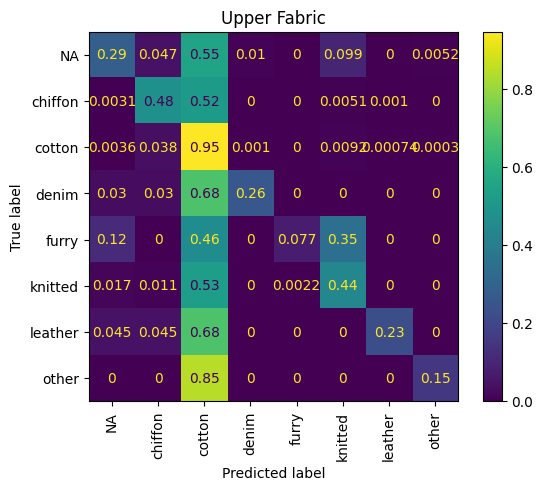

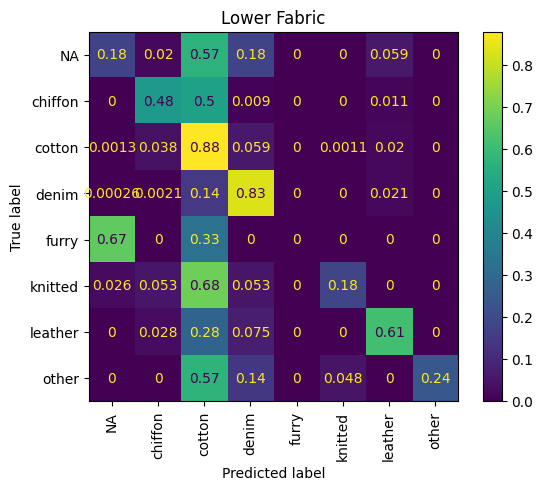

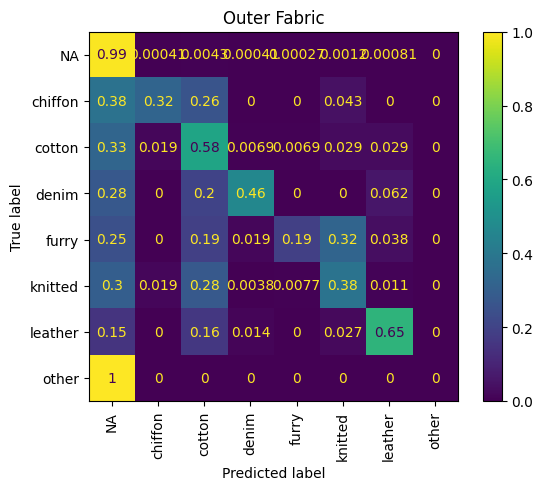

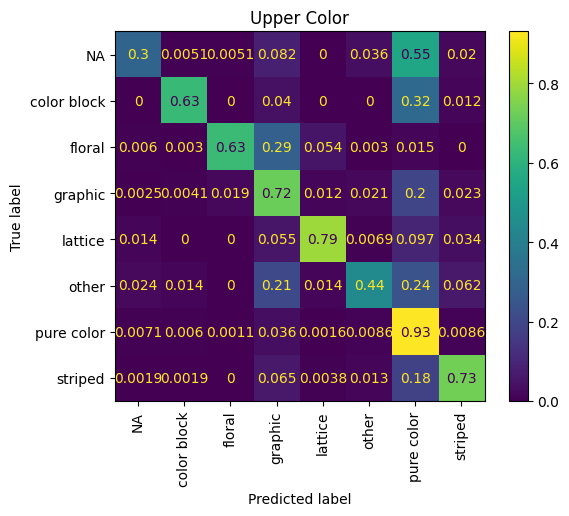

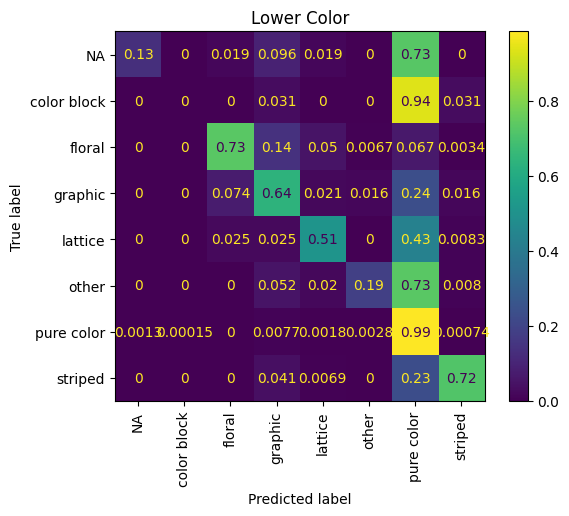

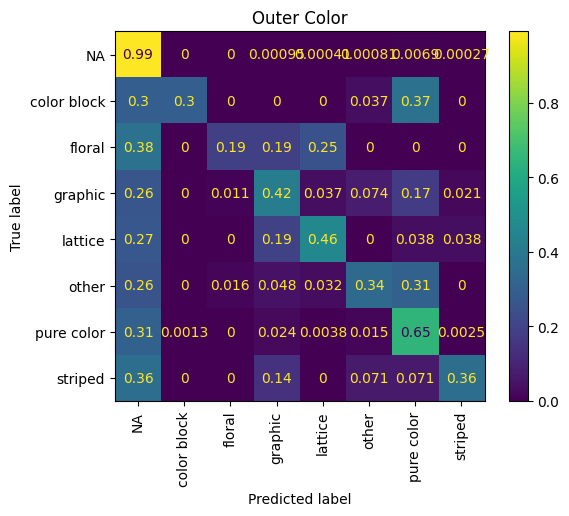

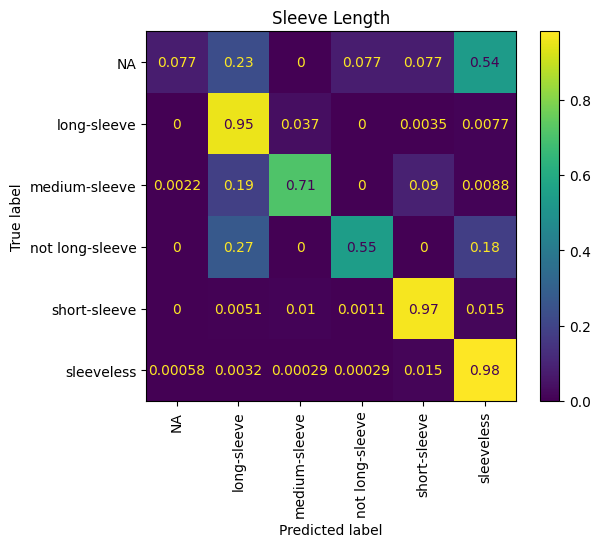

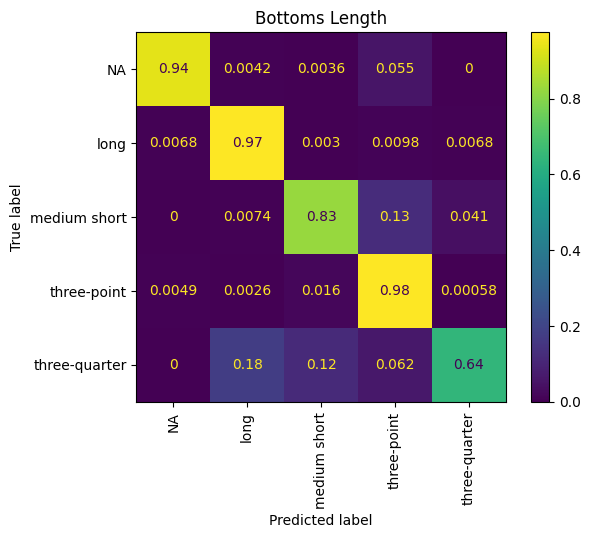

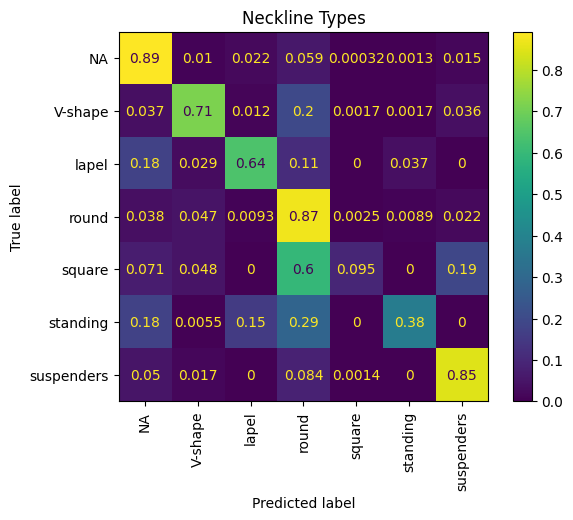

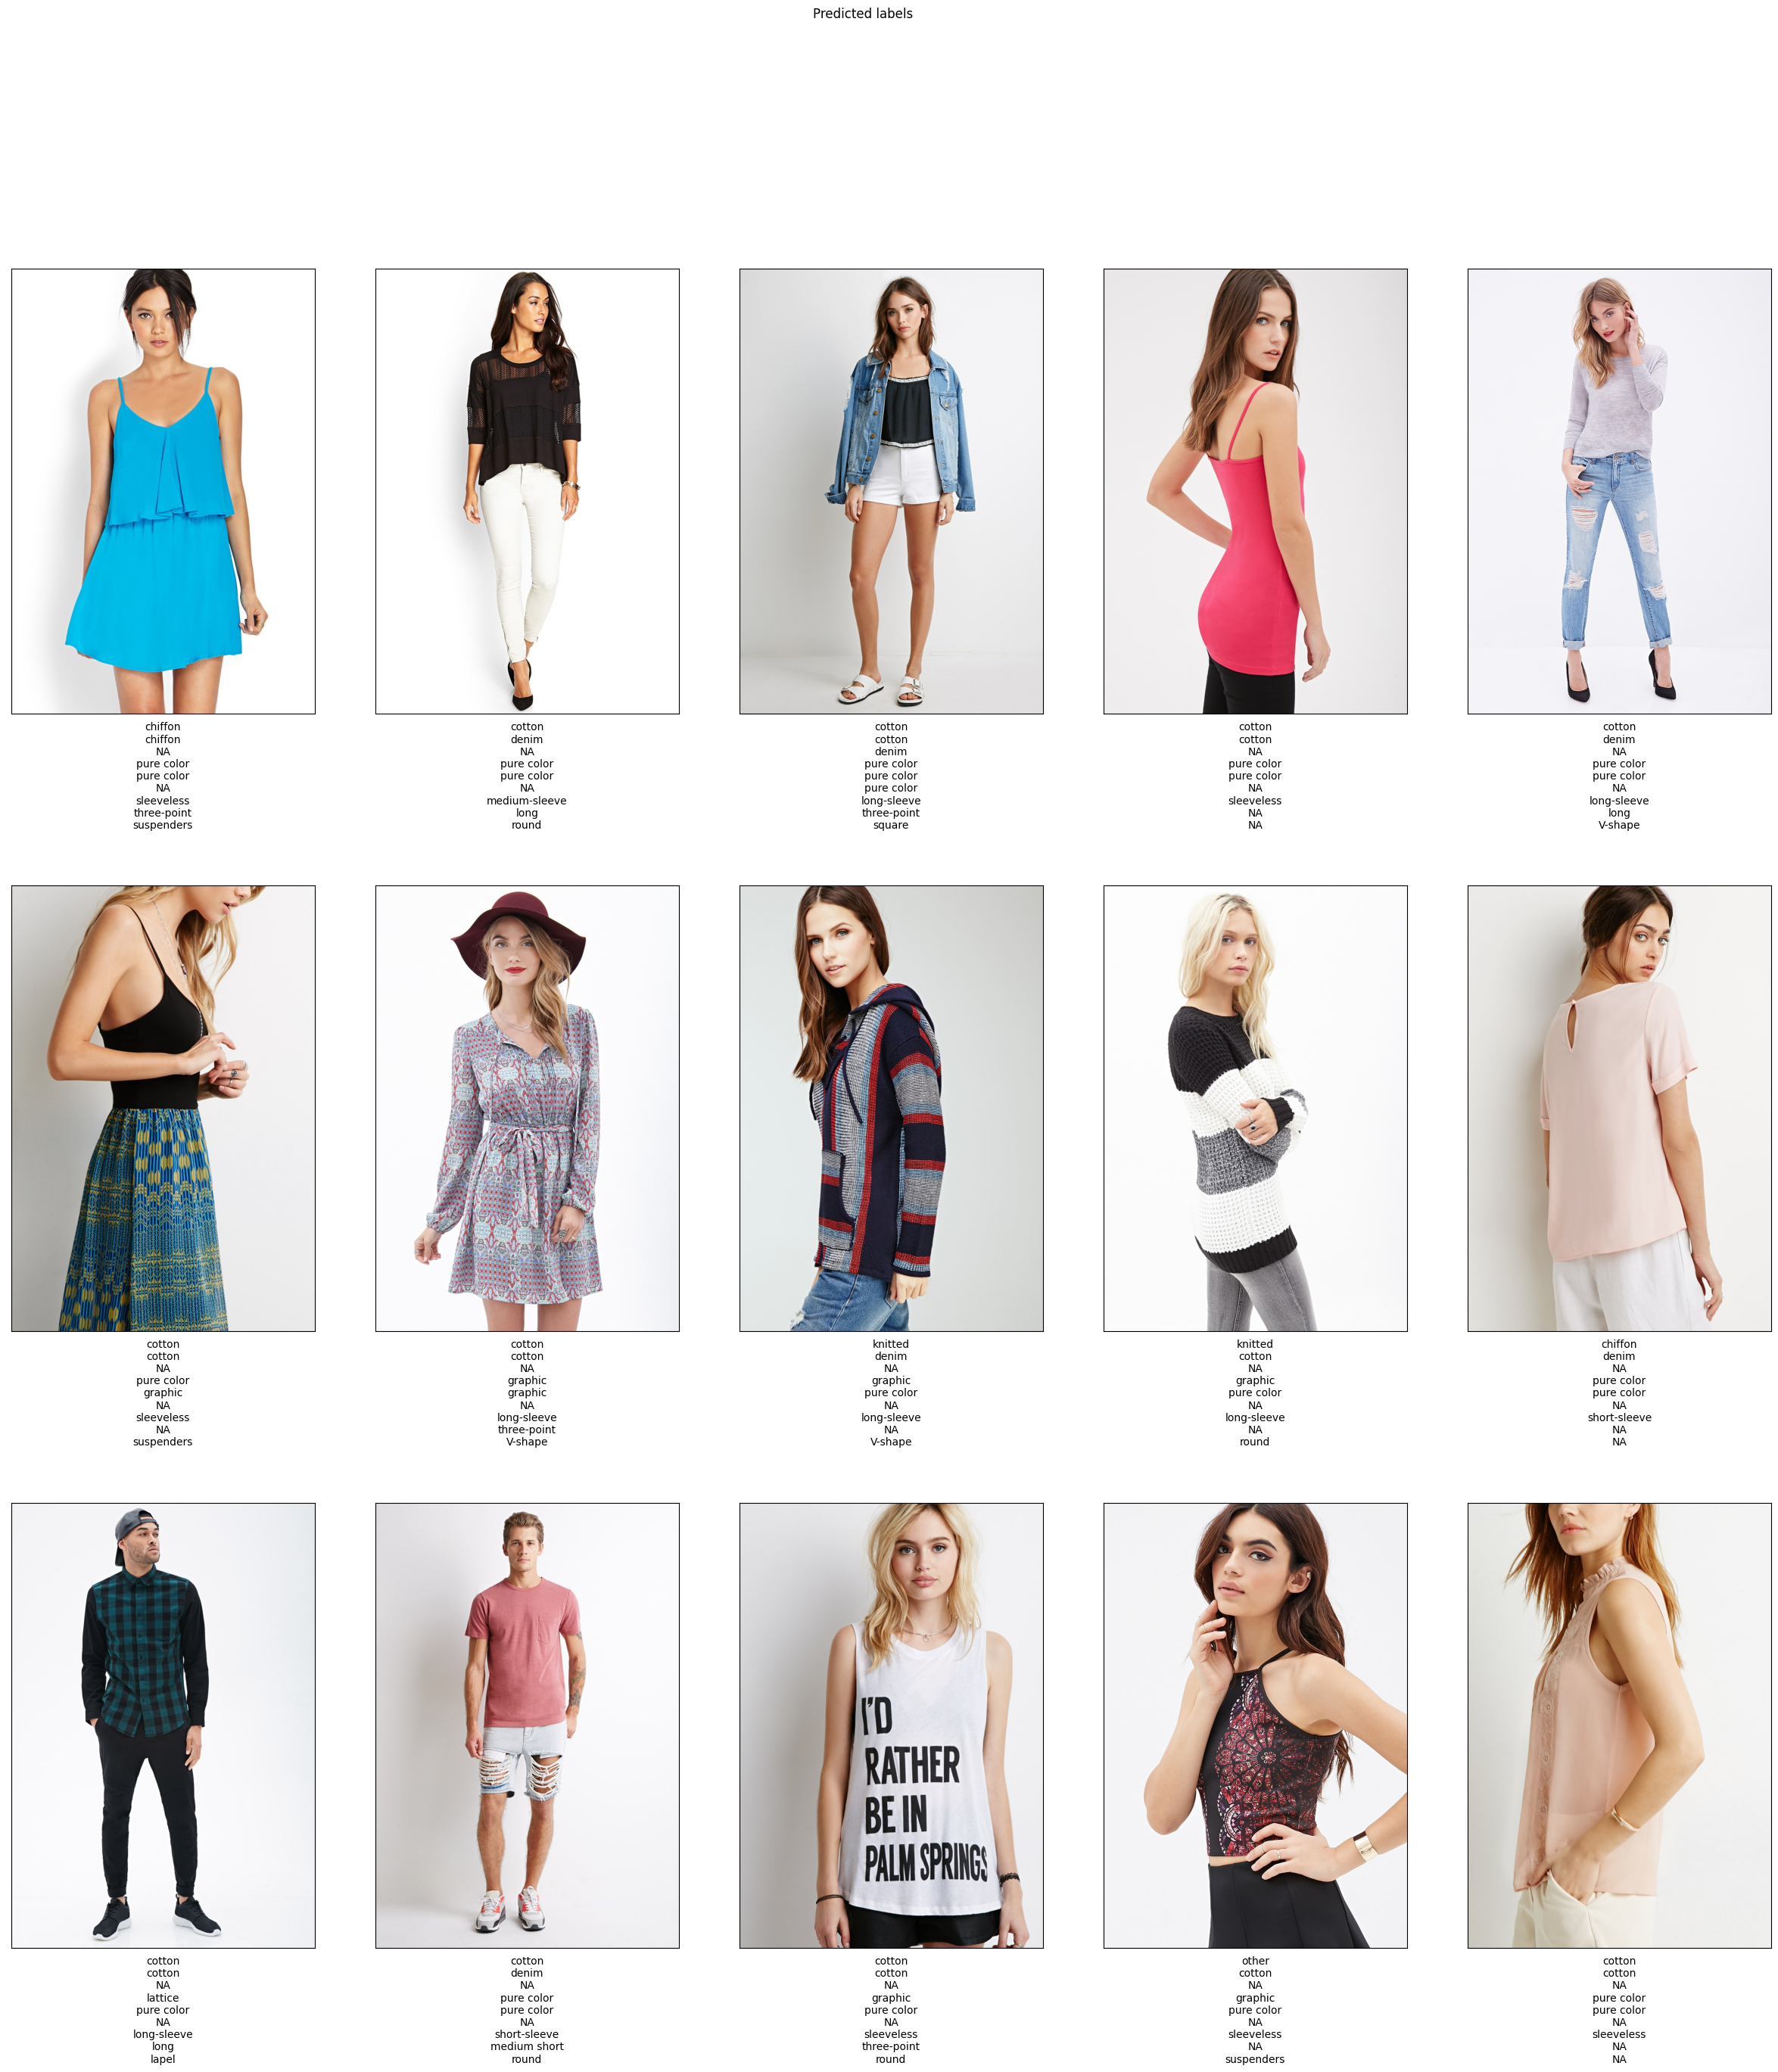

In [ ]:
%matplotlib inline
test(MODEL_50)